# Néobanque : Modèle IA de scoring crédit

## Préparation

### Imports nécessaires

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

## Données

### Chargement des données

In [17]:
import zipfile

# Extraction du ZIP
with zipfile.ZipFile('application_train.zip', 'r') as zip_ref:
    zip_ref.extractall('.')

# Charger les données d'entraînement
train_data = pd.read_csv('application_train.csv').dropna()
print(train_data.head())

     SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
71       100083       0         Cash loans           M            Y   
124      100145       0         Cash loans           F            Y   
152      100179       0         Cash loans           F            Y   
161      100190       0         Cash loans           M            Y   
255      100295       1         Cash loans           M            Y   

    FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
71                Y             0          103500.0    573628.5      24435.0   
124               Y             1          202500.0    260725.5      16789.5   
152               N             0          202500.0    675000.0      53329.5   
161               N             0          162000.0    263686.5      24781.5   
255               N             1          225000.0   1019205.0      31032.0   

     ...  FLAG_DOCUMENT_18 FLAG_DOCUMENT_19 FLAG_DOCUMENT_20 FLAG_DOCUMENT_21  \
71   ...   

Pour rappel, la cible est la colonne TARGET, dont les valeurs sont :
- 1 pour les clients qui ont eu des difficultés de paiement
- 0 pour les autres

### Séparation des variables et préparation des données

In [6]:
# Séparer les variables et la cible pour l'ensemble d'entraînement
X_train = train_data.drop(columns=['TARGET', 'SK_ID_CURR'])  # On enlève la cible et l'identifiant
y_train = train_data['TARGET']  # Cible

### Prétraitement des données

In [7]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Identifier les colonnes catégorielles et numériques
categorical_cols = X_train.select_dtypes(include=['object']).columns
numeric_cols = X_train.select_dtypes(include=['int64', 'float64']).columns

# Créer un transformateur pour encoder les colonnes catégorielles et centrer/réduire les numériques
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ])

# Appliquer le prétraitement
X_train_scaled = preprocessor.fit_transform(X_train)

### Rééquilibrage

Nos données d'entraînement comptent peu de positifs, aussi un rééquilibrage permettra une meilleure représentativité pour la suite. 

In [8]:
from imblearn.over_sampling import SMOTE

print("Nombre de négatifs et positifs avant rééquilibrage :")
print(pd.Series(y_train).value_counts())

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_scaled, y_train)

print("Nombre de négatifs et positifs après rééquilibrage :")
print(pd.Series(y_resampled).value_counts())

Nombre de négatifs et positifs avant rééquilibrage :
TARGET
0    8076
1     526
Name: count, dtype: int64
Nombre de négatifs et positifs après rééquilibrage :
TARGET
0    8076
1    8076
Name: count, dtype: int64


## Évaluation des modèles

L'AUC-ROC (Area Under the Curve - Receiver Operating Characteristic) est une métrique utilisée pour évaluer la performance d'un modèle de classification binaire.  
La courbe ROC trace le taux de vrais positifs (sensibilité) en fonction du taux de faux positifs (1 - spécificité) à différents seuils de décision. L'AUC représente l'aire sous cette courbe : plus elle est proche de 1, meilleur est le modèle (un modèle aléatoire a un AUC de 0.5).

In [9]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

# Définir les modèles à évaluer
models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'AdaBoost': AdaBoostClassifier(random_state=42),
    'XGBoost': XGBClassifier(eval_metric='logloss', random_state=42),
    'KNN': KNeighborsClassifier(),
    'C5.0': DecisionTreeClassifier(random_state=42)  # Alternative à C5.0
}

# Utiliser la validation croisée pour évaluer chaque modèle
for name, model in models.items():
    cv_scores = cross_val_score(model, X_resampled, y_resampled, cv=5, scoring='roc_auc')
    print(f"{name} - AUC-ROC moyen: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")

Random Forest - AUC-ROC moyen: 0.9979 (±0.0042)
AdaBoost - AUC-ROC moyen: 0.9712 (±0.0463)
XGBoost - AUC-ROC moyen: 0.9863 (±0.0274)
KNN - AUC-ROC moyen: 0.9127 (±0.0066)
C5.0 - AUC-ROC moyen: 0.9256 (±0.0374)


Avec un AUC-ROC moyen qui est de 0,9977 soit quasi-parfait, Random Forest est le meilleur modèle pour notre cas.

## Random Forest

In [10]:
from sklearn.ensemble import RandomForestClassifier

# Entraîner le modèle Random Forest sur les données rééquilibrées
final_model = RandomForestClassifier(random_state=42)
final_model.fit(X_resampled, y_resampled)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


#### Seuil Optimal & matrice de confusion

Nous calculons le seuil optimal pour maximiser l'AUC-ROC, en classant une observation comme positive si la probabilité prédite est supérieure à ce seuil optimal.

Poura rappel :
- Seuil bas : Plus de vrais positifs, mais aussi plus de faux positifs.
- Seuil élevé: Moins de faux positifs, mais potentiellement plus de faux négatifs.

Dans notre cas, nous souhaitons surtout éviter les faux positifs, pour éviter de prêter à des clients qui ne pourront pas rembourser.

In [11]:
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_predict

# Obtenir les probabilités prédites par validation croisée
y_probs = cross_val_predict(final_model, X_resampled, y_resampled, cv=5, method='predict_proba')[:, 1]

# Calculer la courbe ROC
fpr, tpr, thresholds = roc_curve(y_resampled, y_probs)

# Trouver le seuil optimal
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

print(f"Seuil optimal : {optimal_threshold:.4f}")

Seuil optimal : 0.3700


Le seuil optimal calculé est de 0,37.
Regardons maintenant des matrices de confusion pour plusieurs seuils. Nous privilégions les seuils bas, pour éviter les faux négatifs (plus de détail plus bas).

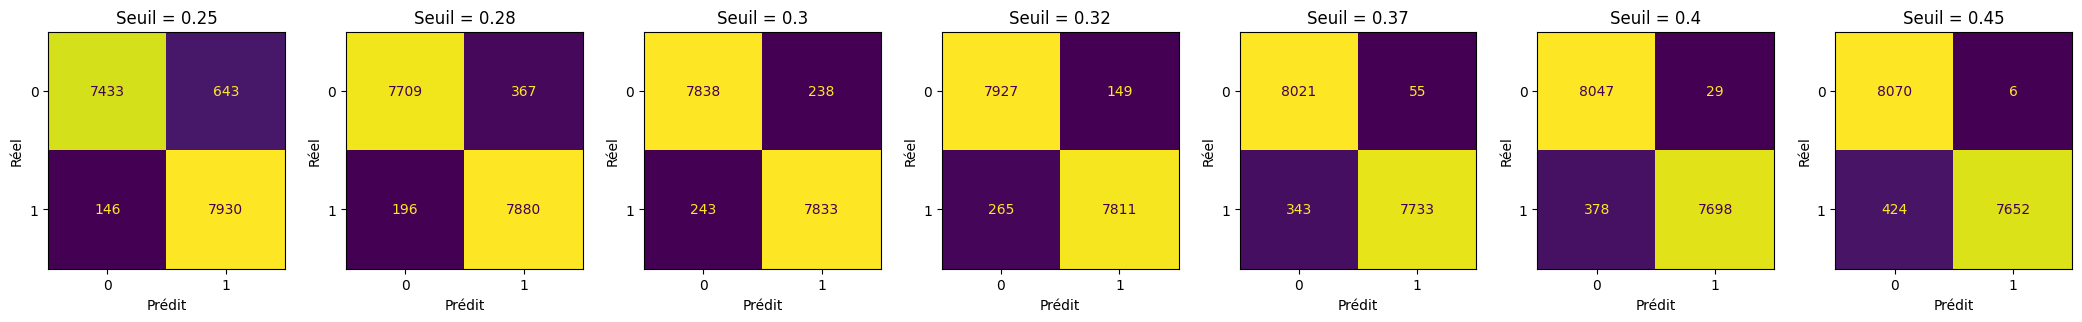

In [12]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Définir une liste de seuils à tester
thresholds = [0.25, 0.28, 0.3, 0.32, optimal_threshold, 0.4, 0.45]

# Créer une figure pour afficher les matrices côte à côte
fig, axes = plt.subplots(1, len(thresholds), figsize=(21, 3))

# Parcourir chaque seuil
for i, threshold in enumerate(thresholds):
    # Prédire les classes avec le seuil
    y_pred = (y_probs >= threshold).astype(int)

    # Calculer la matrice de confusion
    conf_matrix = confusion_matrix(y_resampled, y_pred)

    # Afficher la matrice de confusion
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=[0, 1])
    disp.plot(ax=axes[i], cmap='viridis', colorbar=False)
    axes[i].set_title(f'Seuil = {threshold}')
    axes[i].set_xlabel('Prédit')
    axes[i].set_ylabel('Réel')

plt.tight_layout()
plt.show()

Calculons également les métriques (Précision, Spécificité et Sensibilité)

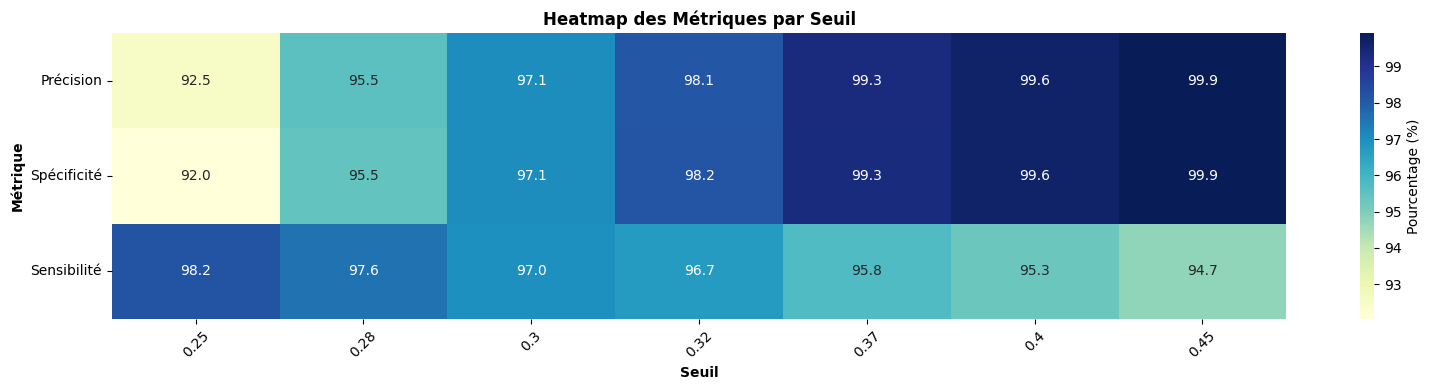

In [13]:
metrics = []
for threshold in thresholds:
    # Prédire les classes avec le seuil
    y_pred = (y_probs >= threshold).astype(int)

    # Calculer la matrice de confusion & les métriques
    tn, fp, fn, tp = confusion_matrix(y_resampled, y_pred).ravel()
    precision = tp / (tp + fp) * 100
    specificity = tn / (tn + fp) * 100
    sensitivity = tp / (tp + fn) * 100

    # Ajouter les métriques à la liste
    metrics.append({
        'Seuil': threshold,
        'Précision': precision,
        'Spécificité': specificity,
        'Sensibilité': sensitivity
    })

metrics_df = pd.DataFrame(metrics)

# Pivot pour la heatmap
metrics_pivot = metrics_df.set_index('Seuil')

# Créer la heatmap
plt.figure(figsize=(16, 4))
sns.heatmap(metrics_pivot.T, annot=True, fmt=".1f", cmap="YlGnBu", cbar_kws={'label': 'Pourcentage (%)'})
plt.title('Heatmap des Métriques par Seuil', fontweight='bold')
plt.xlabel('Seuil', fontweight='bold')
plt.ylabel('Métrique', fontweight='bold')
plt.yticks(rotation=0)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Pour rappel :
- Précision : Proportion de vrais positifs parmi les prédictions positives
- Spécificité : Proportion de vrais négatifs parmi les prédictions négatives
- Sensibilité : Proportion de vrais positifs parmi les vrais positifs réels

Le seuil optimal préalablement calculé (0,37) est effectivement intéressant.
Cependant, les faux négatifs sont les plus coûteux, car ils entraînent un prêt à une personne qui aura des difficultés de paiement. A l'inverse, les faux positifs bien qu'à éviter (refus d'un prêt à tort) sont moins dommageables pour Néobanque.

Nous avons donc besoin d'un seuil avec une bonne sensibilité, tout en gardant une bonne spécificité. 
Nous partons ici sur 0.28. La spécificité de 97,6% nous permet de nous assurer d'un faible taux de faux positifs.

In [14]:
from sklearn.metrics import classification_report

# Prédire les classes avec le seuil de 0.28
y_pred = (y_probs >= 0.28).astype(int)

# Afficher le rapport de classification
print("\nRapport de Classification :")
print(classification_report(y_resampled, y_pred, target_names=['Pas de difficulté de paiement', 'Difficulté de paiement']))


Rapport de Classification :
                               precision    recall  f1-score   support

Pas de difficulté de paiement       0.98      0.95      0.96      8076
       Difficulté de paiement       0.96      0.98      0.97      8076

                     accuracy                           0.97     16152
                    macro avg       0.97      0.97      0.97     16152
                 weighted avg       0.97      0.97      0.97     16152



### Finalisation du modèle et enregistrement

Il est maintenant temps de sauvegarder notre modèle pour exploitation.

In [15]:
import joblib

# Créer un dictionnaire pour stocker le modèle et le seuil
model_data = {
    'model': final_model,
    'seuil': 0.28,
    'preprocessor': preprocessor  # Sauvegarder aussi le preprocessor pour les futures transformations
}

# Sauvegarder le modèle et le seuil dans un fichier
joblib.dump(model_data, '../modele_prediction_credit.joblib')

['../modele_prediction_credit.joblib']